In [10]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pylab as plt
import seaborn as sns
import statsmodels.api as sm
import scipy as sp

## 모형 결합의 기초
- 모형 결합 방법은 앙상블 방법론이라고도 한다.
- 특정한 하나의 예측 방법이 아니라 복수의 예측 모형을 결합하여 더 나은 성능의 예측을 하려는 시도이다.
- 계산량은 증가하지만, 다음과 같은 이점이 있다.
    - 성능 분산이 감소(오버피팅 감소)
    - 개별 모형이 성능이 안좋을 경우에는 결합 모형의 성능이 더 향상된다.

- 취합 방법(aggregation)
    - 취합 방법론은 사용할 모형의 집합이 이미 결정되어 있다.
        - 다수결(Majority Voting) `VotingClassifier`
        - 배깅(Bagging) `BaggingClassifier`
        - 랜덤 포레스트(Random Forests) `RandomFoerestClassifier` , `ExtraTreesClassifier`
- 부스팅 방법(boosting)
    - 부스팅 방법론은 사용할 모형을 점진적으로 늘려간다.
        - 에이다부스트(AdaBoost)
        - 그레디언트 부스트(Gradient Boost)

## Majority Voting
    - hard voting : 단순 투표, 개별 모형의 결과 기준
    - soft voting : 가중치 투표, 개별 모형의 조건부 확률의 합 기준
- `VotingClassifier` 클래스를 제공한다.

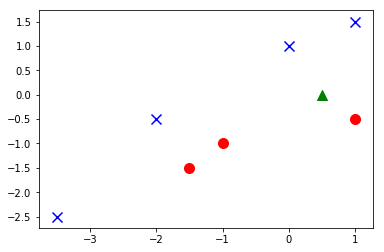

In [5]:
X = np.array([[-1, -1], [-1.5, -1.5], [1, -0.5], 
              [-3.5, -2.5], [0, 1], [1, 1.5], [-2, -0.5]])
y = np.array([1, 1, 1, 2, 2, 2, 2])

plt.scatter(X[y==1,0], X[y==1,1], s=100, marker='o', c='r')
plt.scatter(X[y==2,0], X[y==2,1], s=100, marker='x', c='b')

x_new = [0.5, 0]

plt.scatter(x_new[0], x_new[1], s=100, marker='^', c='g')
plt.show()

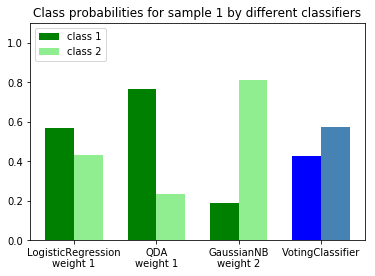

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import VotingClassifier

model1 = LogisticRegression(random_state=1)
model2 = QuadraticDiscriminantAnalysis()
model3 = GaussianNB()
ensemble = VotingClassifier(estimators=[('lr', model1), ('qda', model2), ('gnb', model3)], 
                            voting='soft', weights=[1, 1, 2])

probas = [c.fit(X, y).predict_proba([x_new]) for c in (model1, model2, model3, ensemble)]
class1_1 = [pr[0, 0] for pr in probas]
class2_1 = [pr[0, 1] for pr in probas]

ind = np.arange(4)
width = 0.35  # bar width
p1 = plt.bar(ind, np.hstack(([class1_1[:-1], [0]])), width, color='green')
p2 = plt.bar(ind + width, np.hstack(([class2_1[:-1], [0]])), width, color='lightgreen')
p3 = plt.bar(ind, [0, 0, 0, class1_1[-1]], width, color='blue')
p4 = plt.bar(ind + width, [0, 0, 0, class2_1[-1]], width, color='steelblue')

plt.xticks(ind + 0.5 * width, ['LogisticRegression\nweight 1',
                               'QDA\nweight 1',
                               'GaussianNB\nweight 2',
                               'VotingClassifier'])
plt.ylim([0, 1.1])
plt.title('Class probabilities for sample 1 by different classifiers')
plt.legend([p1[0], p2[0]], ['class 1', 'class 2'], loc='upper left')
plt.show()

/home/hskimim/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


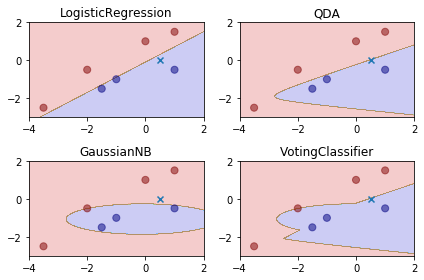

In [11]:
from itertools import product

x_min, x_max = -4, 2
y_min, y_max = -3, 2
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.005), np.arange(y_min, y_max, 0.005))
f, axarr = plt.subplots(2, 2)
for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        [model1, model2, model3, ensemble],
                        ['LogisticRegression', 'QDA', 'GaussianNB', 'VotingClassifier']):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.2, cmap=mpl.cm.jet)
    axarr[idx[0], idx[1]].scatter(X[:, 0], X[:, 1], c=y, alpha=0.5, s=50, cmap=mpl.cm.jet)
    axarr[idx[0], idx[1]].scatter(x_new[0], x_new[1], marker='x')
    axarr[idx[0], idx[1]].set_title(tt)
plt.tight_layout()    
plt.show()

/home/hskimim/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `comb` is deprecated!
Importing `comb` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.comb` instead.
  after removing the cwd from sys.path.


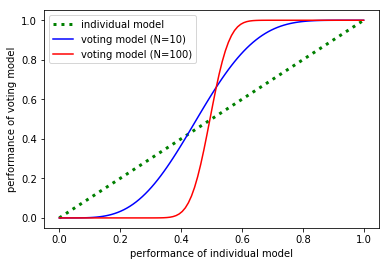

In [12]:
def total_error(p, N):
    te = 0.0
    for k in range(int(np.ceil(N/2)), N + 1):
        te += sp.misc.comb(N, k) * p**k * (1-p)**(N-k)
    return te

x = np.linspace(0, 1, 100)
plt.plot(x, x, 'g:', lw=3, label="individual model")
plt.plot(x, total_error(x, 10), 'b-', label="voting model (N=10)")
plt.plot(x, total_error(x, 100), 'r-', label="voting model (N=100)")
plt.xlabel("performance of individual model")
plt.ylabel("performance of voting model")
plt.legend(loc=0)
plt.show()

## 배깅
- 앞서 모형 결합에서 사용하는 독립적인 모형의 수가 많을 수록 성능 향상이 일어날 가능성이 높다는 것을 알았다. 각각 다른 확률 모형을 사용하는데에는 한계가 있으므로 보통은 배깅 방법을 사용하여 같은 확률 모형을 쓰지만 서로 다른 결과를 출력하는 다수의 모형을 만든다.
- Pasting : 같은 데이터 샘플을 중복 사용하지 않으면
- Bagging : 같은 데이터 샘플을 중복 사용하면
- Random Subspaces : 데이터가 아니라 다차원 독립 변수 중 일부 차원을 선택하는 경우
- Random Patches : 데이터 샘플과 독립 변수 차원 모두 일부만 랜덤하게 사용하면
- 성능 평가시에는 트레이닝용으로 선택한 데이터가 아닌 다른 데이터를 사용할 수도 있다. 이런 데이터를 OOB(out-of-bag) 데이터라고 한다.
- Scikit-Learn 의 앙상블 패키지는 배깅 모형 결합을 위한 `BaggningClassifier` 클래스를 제공한다.

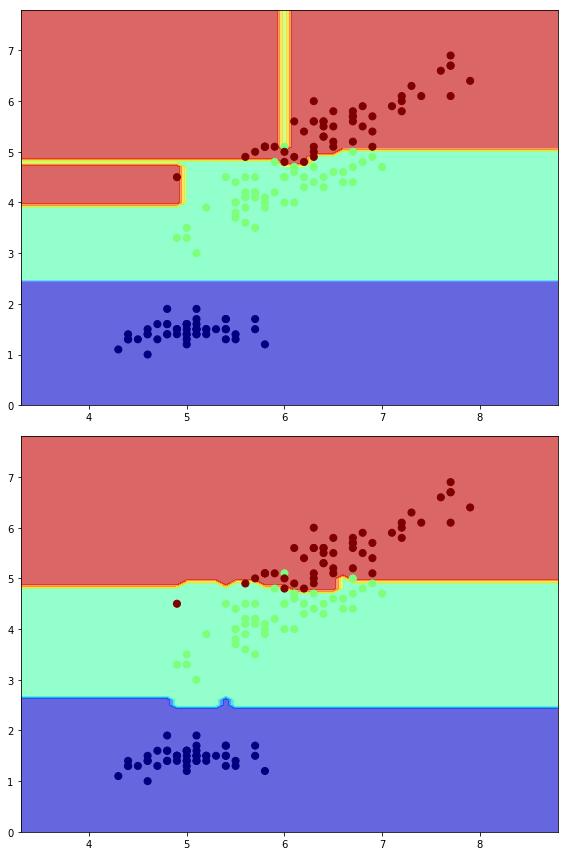

In [13]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier

iris = load_iris()
X, y = iris.data[:, [0, 2]], iris.target

model1 = DecisionTreeClassifier().fit(X, y)
model2 = BaggingClassifier(DecisionTreeClassifier(), bootstrap_features=True, random_state=0).fit(X, y)

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

plt.figure(figsize=(8,12))

plt.subplot(211)
Z1 = model1.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.contourf(xx, yy, Z1, alpha=0.6, cmap=mpl.cm.jet)
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=1, s=50, cmap=mpl.cm.jet)

plt.subplot(212)
Z2 = model2.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.contourf(xx, yy, Z2, alpha=0.6, cmap=mpl.cm.jet)
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=1, s=50, cmap=mpl.cm.jet)

plt.tight_layout()
plt.show()

## 랜덤 포레스트
- 의사 결정 나무를 개별 모형으로 사용하는 모형 결합 방법을 말한다.
- 배깅과 마찬가지로 데이터 샘플의 일부만 선택하여 사용한다.
- 하지만 노드 분리시 모든 독립 변수들을 비교하여 최선의 독립 변수를 선택하는 것이 아니라 독립 변수 차원을 랜덤하게 감소시킨 다음, 그 중에서 독립 변수를 선택한다. 이렇게 하면 개별 모형들 사이의 상관관계가 줄어들기 때문에 모형 성능의 변동이 감소하는 효과가 있다.
- `RandomForestClassifier` , `ExtraTreesClassifier` 클래스로 구현되어 있다.

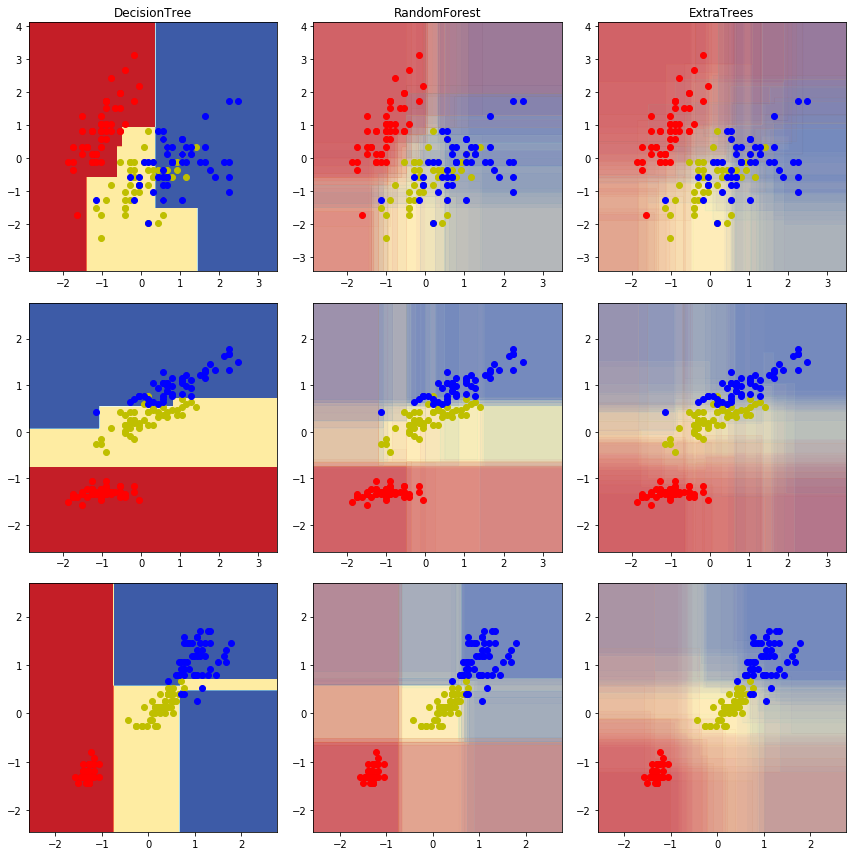

In [14]:
from sklearn import clone
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()

n_classes = 3
n_estimators = 30
plot_colors = "ryb"
cmap = plt.cm.RdYlBu
plot_step = 0.02
seed = 13

models = [DecisionTreeClassifier(max_depth=4),
          RandomForestClassifier(max_depth=4, n_estimators=n_estimators),
          ExtraTreesClassifier(max_depth=4, n_estimators=n_estimators)]

plot_idx = 1
plt.figure(figsize=(12, 12))
for pair in ([0, 1], [0, 2], [2, 3]):
    for model in models:
        X = iris.data[:, pair]
        y = iris.target

        idx = np.arange(X.shape[0])
        np.random.seed(seed)
        np.random.shuffle(idx)
        X = X[idx]
        y = y[idx]

        mean = X.mean(axis=0)
        std = X.std(axis=0)
        X = (X - mean) / std

        clf = clone(model)
        clf = model.fit(X, y)

        plt.subplot(3, 3, plot_idx)
        model_title = str(type(model)).split(".")[-1][:-2][:-len("Classifier")]
        if plot_idx <= len(models):
            plt.title(model_title)

        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                             np.arange(y_min, y_max, plot_step))

        if isinstance(model, DecisionTreeClassifier):
            Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            plt.contourf(xx, yy, Z, cmap=cmap)
        else:
            estimator_alpha = 1.0 / len(model.estimators_)
            for tree in model.estimators_:
                Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
                Z = Z.reshape(xx.shape)
                plt.contourf(xx, yy, Z, alpha=estimator_alpha, cmap=cmap)

        for i, c in zip(range(n_classes), plot_colors):
            idx = np.where(y == i)
            plt.scatter(X[idx, 0], X[idx, 1], c=c,
                        label=iris.target_names[i], cmap=cmap)

        plot_idx += 1

plt.tight_layout()
plt.show()

- 랜덤 포레스트의 장점 중 하나는 각 독립 변수의 중요도를 계산할 수 있다는 점이다.
- 포레스트 안에서 사용된 모든 노드에 대해 어떤 독립 변수를 사용하였고 그 노드에서 얻은 information gain을 구할 수 있으므로 각각의 독립 변수들이 얻어낸 information gain의 평균을 비교하면 어떤 독립 변수가 중요한지를 비교할 수 있다.

Feature ranking:
1. feature 1 (0.295902)
2. feature 2 (0.208351)
3. feature 0 (0.177632)
4. feature 3 (0.047121)
5. feature 6 (0.046303)
6. feature 8 (0.046013)
7. feature 7 (0.045575)
8. feature 4 (0.044614)
9. feature 9 (0.044577)
10. feature 5 (0.043912)


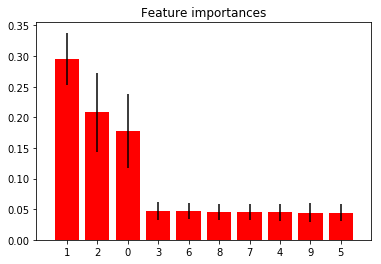

In [15]:
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

X, y = make_classification(n_samples=1000, n_features=10, n_informative=3, n_redundant=0, n_repeated=0,
                           n_classes=2, random_state=0, shuffle=False)

forest = ExtraTreesClassifier(n_estimators=250, random_state=0)
forest.fit(X, y)

importances = forest.feature_importances_

std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

print("Feature ranking:")
for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

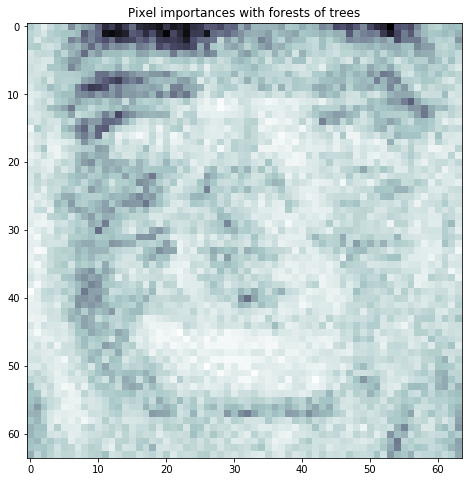

In [16]:
from sklearn.datasets import fetch_olivetti_faces
from sklearn.ensemble import ExtraTreesClassifier

data = fetch_olivetti_faces()
X = data.data
y = data.target

forest = ExtraTreesClassifier(n_estimators=1000, random_state=0)
forest.fit(X, y)

importances = forest.feature_importances_
importances = importances.reshape(data.images[0].shape)

plt.figure(figsize=(8, 8))
plt.imshow(importances, cmap=plt.cm.bone_r)
plt.grid(False)
plt.title("Pixel importances with forests of trees")
plt.show()

based on : http://scikit-learn.org/stable/modules/ensemble.html#forest

## Emsemble methods
- The goal of ensemble methods is to combine the predictions of several base estimators built with a given learning algorithm in order to improve `generalizability/robustness` over a single estimator.
- Two families of ensemble methods are susally distinguished:
    - averaging methods(aggregating)
        - Bagging methods,Forests of randomized trees, Majority voting
    - boosting methods
        - AdaBoost, Grandient Tree Boosting

### Bagging meta-estimator
- 각각 다른 확률 모형을 사용하는데에는 한계가 있으므로 보통은 배깅 방법을 사용하여 같은 확률 모형을 쓰지만 서로 다른 결과를 출력하는 다수의 모형을 만든다.
- In scikit-learn baggin methods are offered as a unified `BaggingClassifier` meta-estimator 
- sklearn.ensemble.BaggingClassifier(base_estimator=None, n_estimators=10, max_samples=1.0, max_features=1.0, bootstrap=True, bootstrap_features=False, oob_score=False, warm_start=False, n_jobs=1, random_state=None, verbose=0)
- base_estimator : 기본 모형
- n_estimators : 데이터 샘플 중 선택할 샘플의 수 혹은 비율
- max_features: 다차원 독립 변수 중 선택할 차원의 수 혹은 비율
- bootstrap :  데이터 중복 사용 여부
- bootstrip_features : 차원 중복 사용 여부
- oob_score : 성능 평가시 OOB 샘플 사용 여부

In [34]:
from sklearn.ensemble import BaggingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
bagging = BaggingClassifier(LinearDiscriminantAnalysis(),max_samples=0.5,\
                           max_features=0.5)
bagging

BaggingClassifier(base_estimator=LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001),
         bootstrap=True, bootstrap_features=False, max_features=0.5,
         max_samples=0.5, n_estimators=10, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

### Forests of randomized trees
- Random Forests
- Extremely Randomized Trees
- Parameters
- Parallelization
- Features importance evaluation
- Totally Random Trees Embedding

#### Random Forests
- each tree in the ensemble is built from a sample drawn with replacement from the training set. In addition, when splitting a node during the construction of the tree, the split that is chosen is no longer the `best split among all features`. Instead, the split that si picked is the best split among a `random subset of the features`. As a result of this randomness, the bias of the forest usually slightly increases (with respect to the bias of a single non-random tree) but, due to averaging, its variance also decreases, usually more than compensating for the increase in bias, hence yielding an overall better model.

#### Extremely Randomized Trees
In extremely randomized trees (see ExtraTreesClassifier and ExtraTreesRegressor classes), randomness goes one step further in the way splits are computed. As in random forests, a random subset of candidate features is used, but instead of looking for the most discriminative thresholds, thresholds are drawn at random for each candidate feature and the best of these randomly-generated thresholds is picked as the splitting rule. This usually allows to reduce the variance of the model a bit more, at the expense of a slightly greater increase in bias:

In [36]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

In [37]:
X, y = make_blobs(n_samples=10000, n_features=10, centers=100,
    random_state=0)

In [39]:
clf = DecisionTreeClassifier(max_depth=None,min_samples_split=2,\
                            random_state=0)
scores = cross_val_score(clf,X,y)
scores.mean()

0.9794087938205586

In [40]:
clf = RandomForestClassifier(max_depth=None,min_samples_split=2,\
                            random_state=0)
scores = cross_val_score(clf,X,y)
scores.mean()

0.9996078431372549

In [41]:
clf = ExtraTreesClassifier(n_estimators=10,max_depth=None,\
                          min_samples_split=2,random_state=0)
scores = cross_val_score(clf,X,y)
scores.mean()

0.99989898989899

### Feature importance evaluation
- 포레스트 안에서 사용된 모든 노드에 대해 어떤 독립 변수를 사용하였고 그 노드에서 얻은 information gain을 구할 수 있으므로 각각의 독립 변수들이 얻어낸 information gain의 평균을 비교하면 어떤 독립 변수가 중요한지를 비교할 수 있다.

- This examples shows the use of forests of trees to evaluate the importance of features on an artificial classification task.

In [42]:
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

In [46]:
print(__doc__)

# Build a classification task using 3 informative features
X, y = make_classification(n_samples=1000,
                           n_features=10,
                           n_informative=3,
                           n_redundant=0,
                           n_repeated=0,
                           n_classes=2,
                           random_state=0,
                           shuffle=False)

# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

Automatically created module for IPython interactive environment


In [44]:
forest.fit(X,y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

Feature ranking:
1. feature 1 (0.295902)
2. feature 2 (0.208351)
3. feature 0 (0.177632)
4. feature 3 (0.047121)
5. feature 6 (0.046303)
6. feature 8 (0.046013)
7. feature 7 (0.045575)
8. feature 4 (0.044614)
9. feature 9 (0.044577)
10. feature 5 (0.043912)


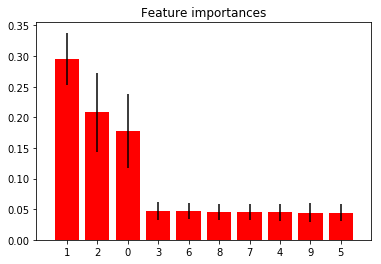

In [45]:
# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

## Random forest vs Extremely Randomized Trees
- 두 모델 모두 의사 결정 나무를 개별 모형으로 사용하는 모형 결합 방법을 말한다.
- Random forest
    - 배깅과 마찬가지로 데이터 샘플의 일부만 선택하여 사용한다.
    - 노드 분리시 모든 독립 변수들을 비교하여 최선의 독립 변수를 선택하는 것이 아니라 독립 변수 차원을 랜덤하게 감소시킨 다음 그 중에서 독립 변수를 선택한다.
    - 개별 모형들 사이의 상관관계가 줄어들기 때문에 모형 성능의 변동이 감소하는 효과가 있다.
- Extremely Randomized Trees
    - 랜덤 포레스트를 극단적으로 적용한 것이다.
    - 각 노드에서 랜덤하게 독립 변수를 선택한다.

### apply to Iris dataset

In [47]:
from sklearn.datasets import load_iris
iris = load_iris()
X,y = iris.data,iris.target

In [65]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier,ExtraTreesClassifier,RandomForestClassifier,VotingClassifier
kfold = KFold(10)

In [51]:
clf1 = BaggingClassifier(DecisionTreeClassifier(),bootstrap_features=True, random_state=0).fit(X, y)
clf1


BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=True, bootstrap_features=True, max_features=1.0,
         max_samples=1.0, n_estimators=10, n_jobs=1, oob_score=False,
         random_state=0, verbose=0, warm_start=False)

In [53]:
clf2 = ExtraTreesClassifier(max_depth=4, n_estimators=n_estimators)
clf2                        

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=4, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [54]:
clf3 = RandomForestClassifier(max_depth=4, n_estimators=n_estimators)
clf3

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [70]:
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
clf4 = VotingClassifier(estimators=[('lr', model1), ('qda', model2), ('gnb', model3)], 
                            voting='soft', weights=[1, 1, 2])
clf4

VotingClassifier(estimators=[('lr', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf...ore=False,
         random_state=0, verbose=0, warm_start=False)), ('gnb', GaussianNB(priors=None))],
         flatten_transform=None, n_jobs=1, voting='soft',
         weights=[1, 1, 2])

In [66]:
np.mean(cross_val_score(clf1,X,y,cv=kfold))

0.9466666666666667

In [67]:
np.mean(cross_val_score(clf2,X,y,cv=kfold))

0.9333333333333333

In [68]:
np.mean(cross_val_score(clf3,X,y,cv=kfold))

0.9466666666666667

In [71]:
np.mean(cross_val_score(clf4,X,y,cv=kfold))

/home/hskimim/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hskimim/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hskimim/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hskimim/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

0.9533333333333334

based on : https://machinelearningmastery.com/ensemble-machine-learning-algorithms-python-scikit-learn/

### Combine Model Predictions Into Ensemble Predictions
- the three most popular methods for combining the predictions from different models are:
    - Bagging : Builiding multiple models from different subsamples of the training dataset.
    - Boosting : Building multiple models each of which learns to fix the prediction errors of a prior model in the chain.
    - Vothing : Building multiple models (typically of differing types) and simple statistics (like calculating the mean) are used to combine predictions.

### 1. Bagged Decision Trees

In [24]:
from sklearn.model_selection import KFold,train_test_split,cross_val_score
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris

iris = load_iris()
dfX = pd.DataFrame(iris.data,columns=iris.feature_names)
dfy = pd.DataFrame(iris.target,columns=['y'])
X,y = iris.data,iris.target

In [25]:
seed = 7
train_X,test_X,train_y,test_y = train_test_split(X,y,test_size=0.2,random_state=seed,shuffle=True)

In [26]:
train_X.shape,test_X.shape,train_y.shape,test_y.shape

((120, 4), (30, 4), (120,), (30,))

In [28]:
kfold = KFold(10,random_state=seed)
cart = DecisionTreeClassifier()
num_trees = 100
model = BaggingClassifier(base_estimator=cart,n_estimators=num_trees,random_state=seed)
results = cross_val_score(model,dfX,dfy,cv=kfold)
print(results.mean())

/home/hskimim/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hskimim/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hskimim/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hskimim/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please chan

0.9466666666666667


/home/hskimim/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [32]:
seed = 7
num_trees = 100
max_features = 3
kfold = KFold(10,random_state=seed)
model = RandomForestClassifier(n_estimators=num_trees,max_features=max_features)
result = cross_val_score(model,dfX,dfy,cv=kfold)
print(result.mean())

/home/hskimim/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/hskimim/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/hskimim/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/hskimim/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataCon

0.9466666666666667


/home/hskimim/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
